## Estimating intrinsic shape distribution of galaxies. 
The individual ellipticity components e1 and e2 are modelled as a Gaussian Mixture model(GMM). 

In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import mixture
from scipy.integrate import quad, dblquad
from IPython.display import Image
plt.rcParams['figure.figsize'] = (12.0, 8.0) 

## Weak Gravitational Lensing
Bending of light by nearby mass is gravitational lensing. In the weak lensing regime this deflection is impossible to detect in a single background source. However, the presence of the foreground mass can be detected, as a  systematic alignment of background sources around the lensing mass. Weak gravitational lensing is thus an intrinsically statistical measurement.
<mg src="exp_1.png">

## Measuring Shape
The reduced shear describes the shape distortion is described by a 2-component quantity, most conveniently written as a complex number $g$. 
However, galaxies are not intrinsically round, so that the observed ellipticity is a combination of intrinsic ellipticity and shear.
### Reduced Shear:  $g=g_1+ig_2=|g|e^{i2\phi}$  ;       Intrinsic ellipticity: $e=e_1+ie_2=|e|e^{i2\beta}$ 


### Shape after lensing: $e^{lens}=\frac{e+g}{1+g^*e}$

Estimating the reduced shear:  We make the assumption that the intrinsic orientation of galaxies ($e$) is random $<e>$=0
If |g|<1 :  $<e_{lens}>=g $

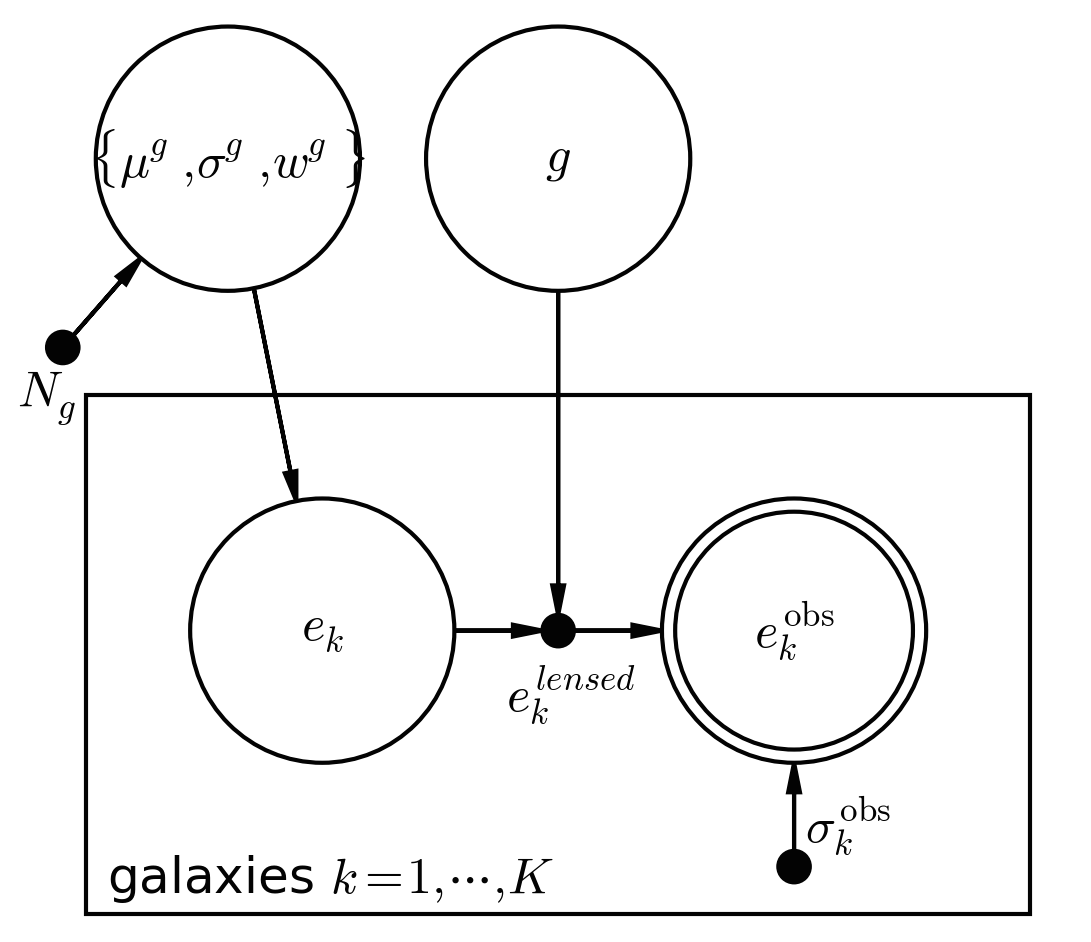

In [2]:
# Display:
Image(filename="flubber_PGM.png",width=800)

The intrinsic shape distribution in modelled as a Gaussian Mixture Model(GMM). The ellipticity components are expressed a a sum of gaussians, {$w_i,\sigma_i$}, with variances $\sigma_i^2$ with weights $w_i$

### $Pr(e_1,e_2)=\Sigma_i^{N_g} w_{1,i} \mathcal{N}(\mu_{1,i},\sigma_{1,i}) \times \Sigma_i^{N_g} w_{2,i} \mathcal{N}(\mu_{2,i},\sigma_{2,i}) $

Since the galaxies are supposed to be randomly oriented, the mean shape is 0. Hence all $\mu' s$ are set to 0

## Data

A catlog of observed shapes of 10000 galaxies measured in the GREAT3 challenge is taken as the input data


In [3]:
data=np.loadtxt('gr3_e.dat')
e=np.hypot(data[0], data[1])
e=(data[0]**2+data[1]**2)**0.5
p,=np.where(e<=0.9)
e1_c=data[0][p]
e2_c=data[1][p]

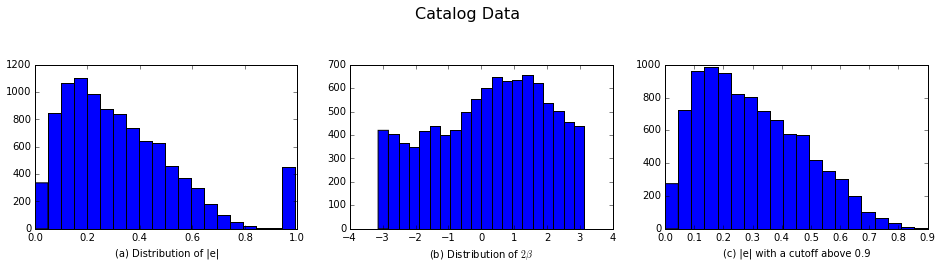

In [31]:
e_cutoff=e[p]
theta=np.arctan2(data[0], data[1]) 
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.hist(e,20)
plt.xlabel('(a) Distribution of |e|')
plt.subplot(3,3,2)
plt.hist(theta,20)
plt.xlabel(r'(b) Distribution of $2\beta $')
plt.subplot(3,3,3)
plt.hist(e_cutoff,20)
plt.xlabel('(c) |e| with a cutoff above 0.9')
plt.suptitle('Catalog Data',size=16)
plt.show()
#plt.savefig('data_nocut.png')

The spike at 1 is due to improper fit as $|e|>1$ is unphysical. So a cutoff is applied at |e|=0.9

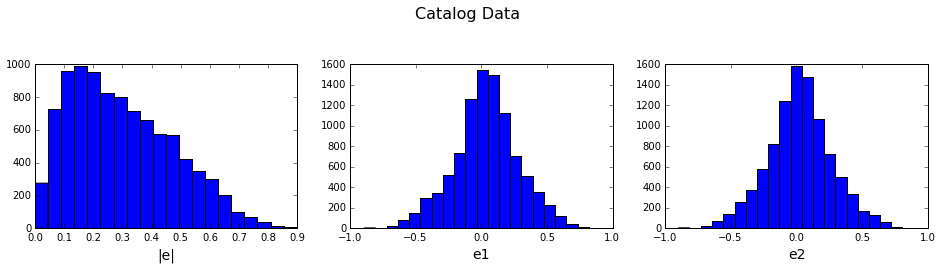

In [5]:
e_cutoff=e[p]
theta=np.arctan(data[1]/data[0])
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.hist(e[p],20)
plt.xlabel('|e|',size=14)
plt.subplot(3,3,2)
plt.hist(e1_c,20)
plt.xlabel('e1',size=14)
plt.subplot(3,3,3)
plt.hist(e2_c,20)
plt.xlabel('e2',size=14)
plt.suptitle('Catalog Data',size=16)
plt.show()
#plt.savefig('data_cut.png')

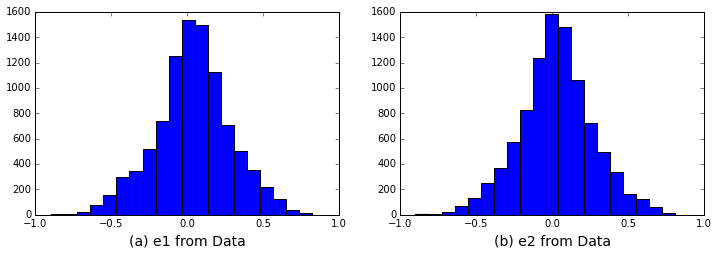

In [6]:
plt.subplot(2,2,1)
plt.hist(e1_c,20)
plt.xlabel('(a) e1 from Data',size=14)
plt.subplot(2,2,2)
plt.hist(e2_c,20)
plt.xlabel('(b) e2 from Data',size=14)
#plt.suptitle('Catalog Data',size=16)
plt.show()
#plt.savefig('data_cut.png')

In [7]:
np.mean(e1_c),np.mean(e2_c)

(0.036611051331978429, 0.024804293786170703)

For $|g|<1$ :  $<e_{obs}>=g $

For the catalog data this value is **g=(0.036611051331978429, 0.024804293786170703)**, which we take as initial point for MCMC later

### Test GMM with scikit-learn GMM and use results as initial points for MCMC later
Run scikit-learn GMM on the Catalog data.

-Note: this data has intrinsic shape and reduced shear information


In [47]:
# creates GMM of Ng components
Ng=5
gmm1=mixture.GMM(n_components=Ng)

#Apply GMM to catalog data
m1=gmm1.fit((np.array([e1_c])).T) 
gmm2=mixture.GMM(n_components=Ng)
m2=gmm2.fit((np.array([e2_c])).T) 
print 'GMM Covars  : ', m1.covars_.T[0]  , m2.covars_.T[0]
print 'GMM Means   : ', m1.means_.T[0]   , m2.means_.T[0]
print 'GMM Weights : ', m1.weights_.T , m2.weights_.T


GMM Covars  :  [ 0.03082883  0.04502797  0.04892056  0.03562787  0.03941959] [ 0.03519586  0.04706688  0.02999935  0.03589137  0.04712446]
GMM Means   :  [ 0.0344879   0.28785546 -0.2525415   0.12199795 -0.06197463] [ 0.10921032 -0.24292603  0.02057135 -0.07024711  0.2851474 ]
GMM Weights :  [ 0.26905396  0.14482999  0.12053637  0.24425599  0.2213237 ] [ 0.23960743  0.12459293  0.27048924  0.227432    0.1378784 ]


In [48]:
def create_gmm_1comp(gmm_param, N):
    '''To return the PDF for a given GMM parameters{mean, weight,variance}
    @param gmm_param: GMM Parameters of the 2 components
    @param N        : No of points to draw
    return GMM PDF of the 2 componets'''
    sum1,sum2=0,0
    x=np.linspace(-1.,1.0,N)
    for i in range(len(gmm_param.means)):
        sum1+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum1

In [49]:
def create_gmm(gmm_param, N):
    '''To return the PDF for a given GMM parameters{mean, weight,variance}
    @param gmm_param: GMM Parameters of the 2 components
    @param N        : No of points to draw
    return GMM PDF of the 2 componets'''
    sum1,sum2=0,0
    x=np.linspace(-1.,1.0,N)
    for i in range(len(gmm_param.means)):
        sum1+=gmm_param.weights[0][i]*np.exp(-((x-gmm_param.means[0][i])**2)/(2*gmm_param.covars[0][i]))/((2*np.pi*gmm_param.covars[0][i])**0.5)
        sum2+=gmm_param.weights[1][i]*np.exp(-((x-gmm_param.means[1][i])**2)/(2*gmm_param.covars[1][i]))/((2*np.pi*gmm_param.covars[1][i])**0.5)
    return np.vstack([sum1,sum2]).T



class gmm_param:
    def __init__(self,means=np.vstack([m1.means_.T[0],m2.means_.T[0]]), 
                 covars=np.vstack([m1.covars_.T[0],m2.covars_.T[0]]),
                 weights=np.vstack([m1.weights_,m2.weights_])):
        self.means=means
        self.weights=weights
        self.covars=covars

e_c=np.vstack([e1_c,e2_c]).T
samp=gmm_param()
d=create_gmm(samp, len(e_c))
x=np.linspace(-1.,1.,len(e_c))

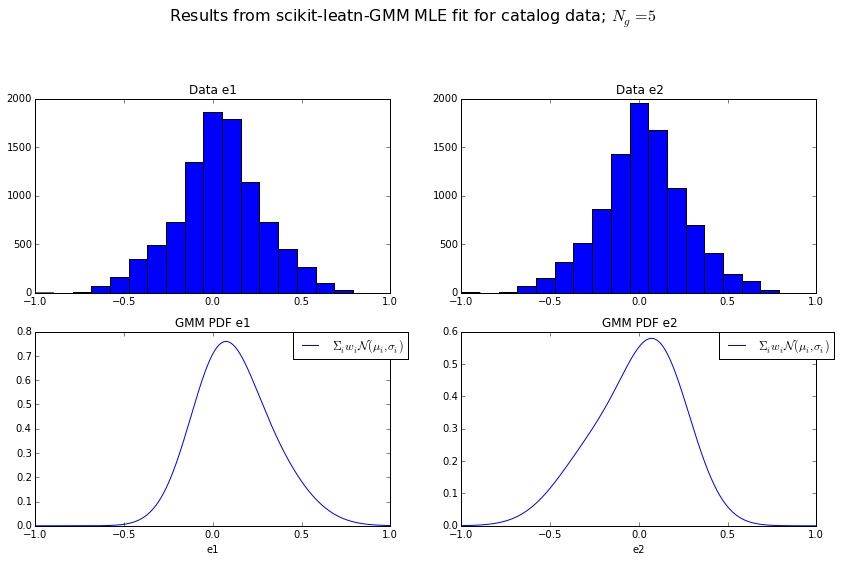

In [50]:
plt.figure(figsize=[14,16])
plt.subplot(4,2,1)
plt.hist(e1_c,np.linspace(-1,1,20))
plt.title('Data e1')
plt.subplot(4,2,2)
plt.hist(e2_c,np.linspace(-1,1,20))
plt.title('Data e2')
plt.subplot(4,2,3)
plt.plot(x,d.T[0],label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.title('GMM PDF e1')
plt.xlabel('e1')
plt.subplot(4,2,4)
plt.plot(x,d.T[1],label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.xlabel('e2')
plt.title('GMM PDF e2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


plt.suptitle('Results from scikit-leatn-GMM MLE fit for catalog data; $N_g=5$',size=16)
plt.show()
#plt.savefig('data_pdf.png')

### Fit Results

In [11]:
# Display:
#Image(filename="flubber_PGM.png",width=800)

## Posterior Probability 
##  $Pr(\{w_i^g,\sigma_i^g,\mu_i^g\},g|e^{obs}) \propto Pr(e^{obs}|\{w_i^g,\sigma_i^g,\mu_i^g\},g) Pr(\{w_i^g,\sigma_i^g\})Pr(g)$ 

### calculate individual terms in posterior

#### Sampling distribution for the kth datapoint, $Pr(e^{obs}_k|e^{lens}_k)$
We choose a Gaussian sampling distribution (with error $\sigma_k$ constant for now):
$Pr(e^{obs}_k|e^{lens}_k,\sigma_k)=\frac{1}{{2\pi}\sigma_k^2} e^{\frac{−(e^{obs}_{1,k}−e^{lens}_{1,k})^2}{2\sigma_k^2} + \frac{−(e^{obs}_{2,k}−e^{lens}_{2,k})^2}{2\sigma_k^2}}$

#### $Pr(e^{obs}|e^{lens},\sigma)=\prod_k\frac{1}{{2\pi}\sigma_k^2} e^{\frac{−(e^{obs}_{1,k}−e^{lens}_{1,k})^2}{2\sigma_k^2} + \frac{−(e^{obs}_{2,k}−e^{lens}_{2,k})^2}{2\sigma_k^2}}$

#### Conditional PDF $Pr(e^{lens}_k|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$
$Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−\frac{e_k+g}{1+g^*e_k})$ 
and  $Pr(e_k|\{w_i,\sigma_i\})=\sum_i^{N_g} w_{1,i}^g \mathcal{N}(0,\sigma_{1,i}^g) \times \sum_i^{N_g} w_{2,i}^g \mathcal{N}(0,\sigma_{2,i}^g)$

The shear is generally much smaller than the galaxy shape.
 To compute the likelihood function analytically we make  approximation $e^{obs}_k=e_k+g$ wich seems valid for $g<<e_k$

### $Pr(e^{lens}_k|e_k,g)=\delta (e^{lens}_k−(e_k+g))$ 

###  Joint likelihood, $Pr(e^{obs}|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$ 

Since the intrinsic ellipticities are not interesting, we marginalize them out:
\begin{align}
Pr(e^{obs}|\{w^g_i,\sigma^g_i,\mu^g_i\},g) & = \prod_{k} \int \int Pr(e^{obs}_k|e^{lens}_k) \times Pr(e^{lens}_k|e_k,g) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k} \int \int  Pr(e^{obs}_k|e^{lens}_k) \times  \delta (e^{lens}_k−(e_k+g)) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_k\frac{1}{{2\pi}\sigma_k^2} e^{\frac{−(e^{obs}_{1,k}−e^{lens}_{1,k})^2}{2\sigma_k^2} + \frac{−(e^{obs}_{2,k}−e^{lens}_{2,k})^2}{2\sigma_k^2}} \times  \sum_i^{N_g} w_{1,i}^g \mathcal{N}(0,\sigma_{1,i}^g) \times \sum_i^{N_g} w_{2,i}^g \mathcal{N}(0,\sigma_{2,i}^g)\\
                                     & = \prod_{k} \sum_i^{N_g}  \int \int \bigg( \mathcal{N}((e^{obs}_{1,k}-(e_{1,k}+g)),\sigma_k) \times   w_{1,i}^g \mathcal{N}(0,\sigma_{1,i}^g) \bigg) \times \bigg( \mathcal{N}((e^{obs}_{2,k}-(e_{2,k}+g)),\sigma_k)  \times   w_{2,i}^g \mathcal{N}(0,\sigma_{2,i}^g) \bigg) de_{1,k}de_{2,k}\end{align} 

The multiplication of two normal functions is a gaussian  function with a normal function as normalization factor. Integrating over $e_k$ gives
 $Pr(e^{obs}|\{w_i,\sigma_i\},g)  = \prod_{k} \sum_i^{N_g} \frac{ w_{1,i}^g  \mathcal{exp}\bigg(\frac{-(g_1-e^{obs}_{1,k})^2}{2 (\sigma_k^2+\sigma_{1,i}^g})\bigg ) \times w_{2,i}^g  \mathcal{exp}\bigg(\frac{-(g_2-e^{obs}_{2,k})^2}{2 (\sigma_k^2+\sigma_{2,i}^g})\bigg )} {2 \pi \sqrt{(\sigma_k^2+\sigma_{1,i}^g) (\sigma_k^2+\sigma_{2,i}^g)}}$



### Priors
For simplicity we take the GMM parametrs and g are taken to have uniform priors

### Let's MCMC!

- The total number of free parametrs we want to measure are $2(2N_g-1)+2$. 
- $N_g$ gaussians, each with 2 \times 2 parametrs $\{w^g,\sigma^g\}$
- -1 comes from $\sum_i w_i^g=1$ 
- +2 for g

In [12]:
np.random.seed(1)

def log_prior_g(g):
    """Uniform priors for g in (-1,1)"""
    gmin,gmax=np.ones([len(g),2])*-1.,np.ones([len(g),2])*1.
    if ((g>=gmin).all() and (g<=gmax).all()) :
        return np.log(np.mean(1/(gmax-gmin)))
    else:
        return -np.inf
def log_prior_gmm(gmm_param):
    """Uniform priors for w and sigma in (0,1)"""
    N=len(gmm_param.covars[0])
    min_gmm,max_gmm   =np.zeros([2,N]),np.ones([2,N])
    #min2_gmm,max2_gmm =np.ones([2,N])*-1.,np.ones([2,N])*1.
    #if ((gmm_param.means >= min2_gmm).all() and (gmm_param.means  <= max2_gmm).all() and
    if ((gmm_param.covars >= min_gmm).all()  and (gmm_param.covars <= max_gmm).all() and
       (gmm_param.weights>= min_gmm).all()  and (gmm_param.weights<= max_gmm).all() ) :
        return 1.# np.log(np.mean(1/(max2_gmm-min2_gmm)))
    else:
        return -np.inf

In [13]:
def log_likelihood(eobs,gmm_param,g,sigmak):
    """Calculate the joint likelihood as derived above
    @param eobs      : observed [e1,e2] after lensing, with error sigmak 
    @param gmm_param : GMM parameters of intrinsic e1 and e2
    @param g         : shear [g1,g2]
    @sigmak          : error in measuring eobs 
    returns loglikelihood"""
    val=np.zeros(len(eobs))
    #print gmm_param.weights
    for i in range(len(gmm_param.covars[0])):
        C1 = (sigmak**2+gmm_param.covars[0][i])
        C2 = (sigmak**2+gmm_param.covars[1][i])
        t1 = np.exp(-((-eobs.T[0]+g[0])**2)/(2*C1))*gmm_param.weights[0][i]/(2*np.pi*C1)**0.5
        t2 = np.exp(-((-eobs.T[1]+g[1])**2)/(2*C2))*gmm_param.weights[1][i]/(2*np.pi*C2)**0.5
        val+= t1*t2
        #print val
    #print np.sum(np.log(val))
    return np.sum(np.log(val))
    #return val
    
def log_posterior(eobs,gmm_param,g,sigmak):
    """Calculate the posterior probability as derived above
    @param eobs      : observed [e1,e2] after lensing, with error sigmak 
    @param gmm_param : GMM parameters of intrinsic e1 and e2
    @param g         : shear [g1,g2]
    @sigmak          : error in measuring eobs 
    returns log of posterior"""
    return log_likelihood(eobs,gmm_param,g,sigmak)+log_prior_g(g)+log_prior_gmm(gmm_param)

In [14]:
def metropolis( eobs,gmm_param1,g,sigmak, g_stepsize,
               w_stepsize,c_stepsize,nsteps=1000):
    """ Function to perform MCMC
    @param eobs      : observed [e1,e2] after lensing, with error sigmak 
    @param gmm_param : GMM parameters of intrinsic e1 and e2
    @param g         : shear [g1,g2]
    @sigmak          : error in measuring eobs
    @g_stepsize      : float, stepsize of shear [g1,g2] 
    @w_stepsize      : float, stepsize to change weights of GMM
    @c_stepsize      : float, stepsize to change variances of GMM
    @nsteps          : No of seps to run MCMC
    returns g1,g2    : predicted shear
    returns s1,s2    : predicted variances
    returns w1,w2    : predicted weights
    returns log_probs: log of posteriors """
    
    log_prob = log_posterior(eobs,gmm_param1,g,sigmak)
    #print log_prob
    
    # Store Markov chain as an array of samples:
    g1,g2,s1,s2,w1,w2,log_probs = [],[],[],[],[],[],[]
    
    # Count our accepted proposals:
    naccept = 0
    t=0
    for i in range(nsteps):
        g_new        = g + g_stepsize * np.random.uniform(-1,1,2)       
        var_new     = np.array(gmm_param1.covars  + c_stepsize*np.random.uniform(-1,1,[2,len(gmm_param1.covars[0])]))
        weight_new  = np.array(gmm_param1.weights + w_stepsize*np.random.uniform(-1,1,[2,len(gmm_param1.weights[0])]))
        #normalizing the weight fn
        weight_new[0]/= np.sum(weight_new[0])
        weight_new[1]= weight_new[0]
        var_new[1]=var_new[0]
        #print np.sum(weight_new[0][:-1])
        #print mean_new
        gmm_new=gmm_param(covars=var_new, weights=weight_new)
        log_prob_new = log_posterior(eobs,gmm_new,g_new,sigmak)
        #print log_prob_new,log_prob    
        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            gmm_param1=gmm_new
            g = g_new
            log_prob = log_prob_new
            naccept += 1
            
        else:
            # reject, and store the same sample as before:
            pass
        g1.append(g[0])
        g2.append(g[1])
        s1.append(gmm_param1.covars[0])
        s2.append(gmm_param1.covars[1])
        w1.append(gmm_param1.weights[0])
        w2.append(gmm_param1.weights[1])
        log_probs.append(log_prob)

        
    acceptance_rate = naccept/float(nsteps) 
    print 'Acceptance Ratio:',acceptance_rate
    return g1,g2,s1,s2,w1,w2,log_probs

In [19]:

sigmak=0.05
g=[0.036611051331978429, 0.024804293786170703]
input_param=gmm_param()
g_stepsize=0.001
c_stepsize, w_stepsize= 0.001,0.0001
g1,g2,s1,s2,w1,w2,log_probs=metropolis( e_c,input_param,g,sigmak, g_stepsize,w_stepsize,c_stepsize,nsteps=5000)

Acceptance Ratio: 0.5398


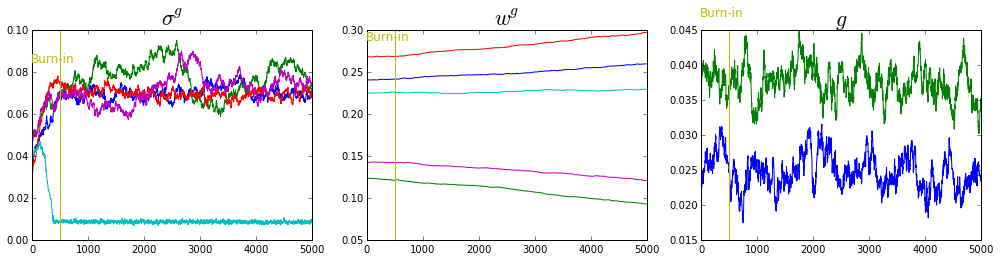

In [20]:
fig = plt.figure(figsize=[14,10])

ax1 = plt.subplot(331)
ax1.plot(s1)
ax1.set_title(r'$\sigma^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(1.088,0.085, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(332)
ax1.plot(w1)
ax1.set_title(r'$w^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.288, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(333)
ax1.plot(g1,'g')
ax1.set_title('$g$',size=22)
ax1.plot(g2,'b')
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.047, 'Burn-in', fontsize = 12, color = 'y')
plt.tight_layout()


#plt.savefig('mcmc_5.png')




In [21]:
new_gmm=gmm_param(means=np.zeros(Ng),covars=np.mean(s1[500:],axis=0),weights=np.mean(w1[500:],axis=0))
def f(gmm_param, x):
    sum=0
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum
xmin = -1.0
xmax = 1.0

# find ymin-ymax
numSteps = 1000000 # bigger the better but slower!
ymin = f(new_gmm,xmin)
ymax = ymin
for i in range(numSteps):
    x = xmin + (xmax - xmin) * float(i) / numSteps
    y = f(new_gmm,x)
    if y < ymin: ymin = y
    if y > ymax: ymax = y

In [22]:
print (np.mean(s1[500:],axis=0),np.mean(w1[500:],axis=0), np.mean(g1),np.mean(g2))

(array([ 0.07003118,  0.07761605,  0.06977592,  0.00854272,  0.07233102]), array([ 0.25014348,  0.10791956,  0.28266851,  0.22703615,  0.13223229]), 0.037592315470945555, 0.024721400800943431)


In [23]:
print (np.std(s1[500:],axis=0),np.std(w1[500:],axis=0), np.std(g1),np.mean(g2))

(array([ 0.00284676,  0.00776782,  0.00216271,  0.00056556,  0.00687613]), array([ 0.00512075,  0.00849454,  0.00805501,  0.00158019,  0.00605001]), 0.0024444522096011851, 0.024721400800943431)


In [24]:
n = len(e1_c) # how many random numbers to generate
e_int=[]
for i in range(n):
    while True:
        # generate a random number between 0 to 1
        xr = np.random.random()
        yr = np.random.random()
        x = xmin + (xmax - xmin) * xr
        y = ymin + (ymax - ymin) * yr
        if y <= f(new_gmm,x):
            e_int.append(x)

            break

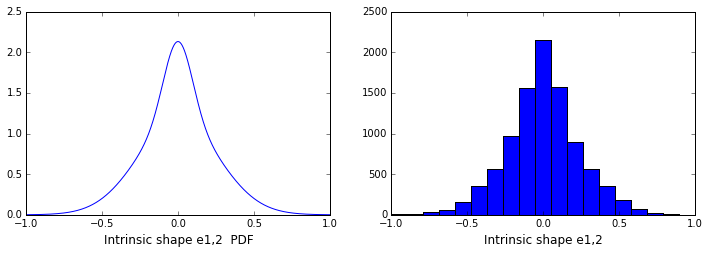

In [32]:
N=len(e1_c)
e_new=np.linspace(-1.,1.0,N)
new_e=create_gmm_1comp(new_gmm, N)

plt.subplot(2,2,1)
plt.plot(e_new,new_e)
plt.xlabel('Intrinsic shape e1,2  PDF',size=12)
plt.subplot(2,2,2)
plt.hist(e_int,np.linspace(-1,1,20))
plt.xlabel('Intrinsic shape e1,2',size=12)
#plt.savefig('result_5.png')


In [33]:
np.random.normal(0,sigmak)

0.08094044937224461

In [34]:
e_obs_cal1=e_int+np.mean(g1)+np.random.normal(0,sigmak)
e_obs_cal2=e_int+np.mean(g2)+np.random.normal(0,sigmak)
e_obs_cal=np.hypot(e_obs_cal1,e_obs_cal1)


In [35]:
np.sum((e_obs_cal1-e1_c)**2/e1_c)

-8298.3757164901854

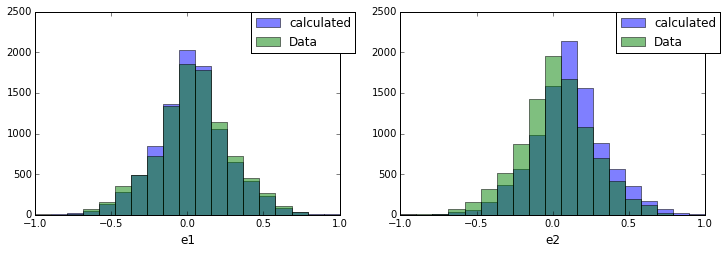

In [36]:
plt.subplot(2,2,1)
plt.hist(e_obs_cal1,np.linspace(-1,1,20),alpha = 0.5, label='calculated')
plt.hist(e1_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e1',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


plt.subplot(2,2,2)
plt.hist(e_obs_cal2,np.linspace(-1,1,20), alpha = 0.5,label='calculated')
plt.hist(e2_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e2',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


#plt.savefig('final_5.png')

In [ ]:
len(e_obs_cal2), len(e1_c)

## Test for Ng=3

In [37]:
#Test for Ng=3
Ng=3
gmm1=mixture.GMM(n_components=Ng)

#Apply GMM to catalog data
m1=gmm1.fit((np.array([e1_c])).T) 
gmm2=mixture.GMM(n_components=Ng)
m2=gmm2.fit((np.array([e2_c])).T) 
print 'GMM Covars  : ', m1.covars_.T[0]  , m2.covars_.T[0]
print 'GMM Means   : ', m1.means_.T[0]   , m2.means_.T[0]
print 'GMM Weights : ', m1.weights_.T , m2.weights_.T

input_param3=gmm_param(means=np.vstack([m1.means_.T[0],m2.means_.T[0]]), 
                 covars=np.vstack([m1.covars_.T[0],m2.covars_.T[0]]),
                 weights=np.vstack([m1.weights_,m2.weights_]))

GMM Covars  :  [ 0.05277126  0.02904302  0.04741264] [ 0.0491537   0.04922682  0.02870879]
GMM Means   :  [-0.16349837  0.03882093  0.21821461] [-0.153986    0.21030151  0.0260068 ]
GMM Weights :  [ 0.27021072  0.43736558  0.2924237 ] [ 0.2900715   0.27677559  0.4331529 ]


In [38]:

sigmak=0.05
g=[0.036611051331978429, 0.024804293786170703]
g_stepsize=0.001
c_stepsize, w_stepsize= 0.001,0.00001
g1,g2,s1,s2,w1,w2,log_probs=metropolis( e_c,input_param3,g,sigmak, g_stepsize,w_stepsize,c_stepsize,nsteps=5000)




Acceptance Ratio: 0.7316


(array([ 0.08343807,  0.03364788,  0.08412831]), array([ 0.2702013,  0.4375447,  0.292254 ]), 0.038103662976114082, 0.024356555061485392)
(array([ 0.00265872,  0.00125627,  0.00235743]), array([  7.87859950e-05,   1.27492053e-04,   9.09389626e-05]), 0.0024030668065999927, 0.024356555061485392)


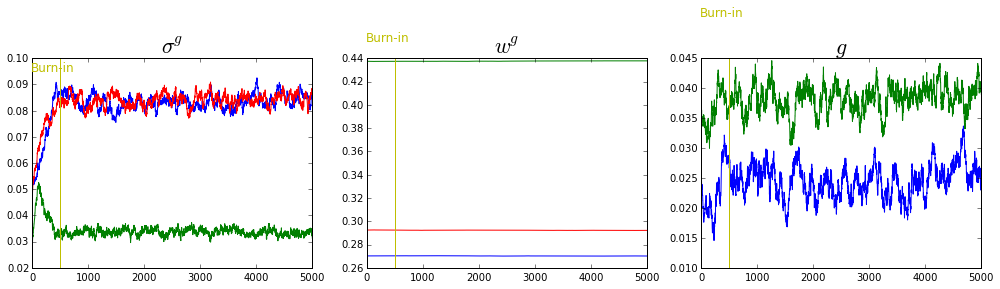

In [39]:
fig = plt.figure(figsize=[14,10])

ax1 = plt.subplot(331)
ax1.plot(s1)
ax1.set_title(r'$\sigma^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(1.088,0.095, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(332)
ax1.plot(w1)
ax1.set_title(r'$w^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.455, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(333)
ax1.plot(g1,'g')
ax1.set_title('$g$',size=22)
ax1.plot(g2,'b')
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.052, 'Burn-in', fontsize = 12, color = 'y')
plt.tight_layout()


#plt.savefig('mcmc_3.png')


print (np.mean(s1[500:],axis=0),np.mean(w1[500:],axis=0), np.mean(g1),np.mean(g2))

print (np.std(s1[500:],axis=0),np.std(w1[500:],axis=0), np.std(g1),np.mean(g2))


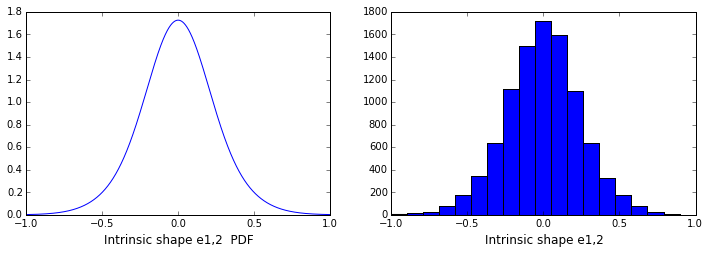

In [40]:
new_gmm=gmm_param(means=np.zeros(Ng),covars=np.mean(s1[500:],axis=0),weights=np.mean(w1[500:],axis=0))
def f(gmm_param, x):
    sum=0
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum
xmin = -1.0
xmax = 1.0

# find ymin-ymax
numSteps = 1000000 # bigger the better but slower!
ymin = f(new_gmm,xmin)
ymax = ymin
for i in range(numSteps):
    x = xmin + (xmax - xmin) * float(i) / numSteps
    y = f(new_gmm,x)
    if y < ymin: ymin = y
    if y > ymax: ymax = y
        
n = len(e1_c) # how many random numbers to generate
e_int=[]
for i in range(n):
    while True:
        # generate a random number between 0 to 1
        xr = np.random.random()
        yr = np.random.random()
        x = xmin + (xmax - xmin) * xr
        y = ymin + (ymax - ymin) * yr
        if y <= f(new_gmm,x):
            e_int.append(x)
            break
N=len(e1_c)
e_new=np.linspace(-1.,1.0,N)
new_e=create_gmm_1comp(new_gmm, N)

plt.subplot(2,2,1)
plt.plot(e_new,new_e)
plt.xlabel('Intrinsic shape e1,2  PDF',size=12)
plt.subplot(2,2,2)
plt.hist(e_int,np.linspace(-1,1,20))
plt.xlabel('Intrinsic shape e1,2',size=12)
#plt.savefig('result_3.png')




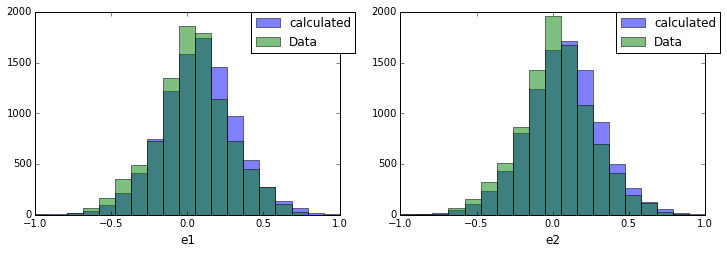

In [41]:
e_obs_cal1=e_int+np.mean(g1)+np.random.normal(0,sigmak)
e_obs_cal2=e_int+np.mean(g2)+np.random.normal(0,sigmak)
e_obs_cal=np.hypot(e_obs_cal1,e_obs_cal1)

plt.subplot(2,2,1)
plt.hist(e_obs_cal1,np.linspace(-1,1,20),alpha = 0.5, label='calculated')
plt.hist(e1_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e1',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


plt.subplot(2,2,2)
plt.hist(e_obs_cal2,np.linspace(-1,1,20), alpha = 0.5,label='calculated')
plt.hist(e2_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e2',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


#plt.savefig('final_3.png')

### Test for Ng=2

In [42]:
#Test for Ng=2
Ng=2
gmm1=mixture.GMM(n_components=Ng)

#Apply GMM to catalog data
m1=gmm1.fit((np.array([e1_c])).T) 
gmm2=mixture.GMM(n_components=Ng)
m2=gmm2.fit((np.array([e2_c])).T) 
print 'GMM Covars  : ', m1.covars_.T[0]  , m2.covars_.T[0]
print 'GMM Means   : ', m1.means_.T[0]   , m2.means_.T[0]
print 'GMM Weights : ', m1.weights_.T , m2.weights_.T

input_param2=gmm_param(means=np.vstack([m1.means_.T[0],m2.means_.T[0]]), 
                 covars=np.vstack([m1.covars_.T[0],m2.covars_.T[0]]),
                 weights=np.vstack([m1.weights_,m2.weights_]))

GMM Covars  :  [ 0.04391538  0.04880594] [ 0.04492407  0.04464966]
GMM Means   :  [ 0.15484859 -0.0904201 ] [ 0.14508233 -0.09432493]
GMM Weights :  [ 0.51792649  0.48207351] [ 0.49760072  0.50239928]


In [43]:

sigmak=0.05
g=[0.036611051331978429, 0.024804293786170703]
g_stepsize=0.001
c_stepsize, w_stepsize= 0.001,0.00001
g1,g2,s1,s2,w1,w2,log_probs=metropolis( e_c,input_param2,g,sigmak, g_stepsize,w_stepsize,c_stepsize,nsteps=5000)



Acceptance Ratio: 0.7216


(array([ 0.03292806,  0.08321768]), array([ 0.51806098,  0.48193902]), 0.037952838734716159, 0.024497882675799616)
(array([ 0.00126847,  0.00174046]), array([ 0.00011123,  0.00011123]), 0.0023380840055928121, 0.024497882675799616)


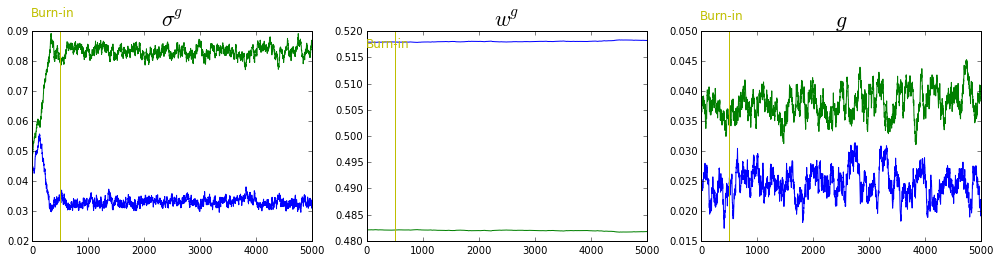

In [44]:
fig = plt.figure(figsize=[14,10])

ax1 = plt.subplot(331)
ax1.plot(s1)
ax1.set_title(r'$\sigma^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(1.088,0.095, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(332)
ax1.plot(w1)
ax1.set_title(r'$w^g$',size=22)
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.517, 'Burn-in', fontsize = 12, color = 'y')

ax1 = plt.subplot(333)
ax1.plot(g1,'g')
ax1.set_title('$g$',size=22)
ax1.plot(g2,'b')
plt.axvline(x=500,color='y')
pylab.text(-1.088,0.052, 'Burn-in', fontsize = 12, color = 'y')
plt.tight_layout()


#plt.savefig('mcmc_2.png')


print (np.mean(s1[500:],axis=0),np.mean(w1[500:],axis=0), np.mean(g1),np.mean(g2))
print (np.std(s1[500:],axis=0),np.std(w1[500:],axis=0), np.std(g1),np.mean(g2))



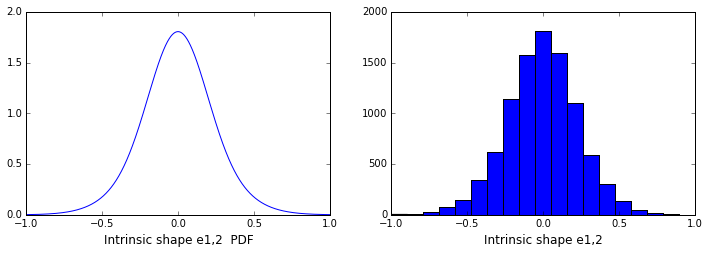

In [45]:
new_gmm=gmm_param(means=np.zeros(Ng),covars=np.mean(s1[500:],axis=0),weights=np.mean(w1[500:],axis=0))
def f(gmm_param, x):
    sum=0
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum
xmin = -1.0
xmax = 1.0

# find ymin-ymax
numSteps = 1000000 # bigger the better but slower!
ymin = f(new_gmm,xmin)
ymax = ymin
for i in range(numSteps):
    x = xmin + (xmax - xmin) * float(i) / numSteps
    y = f(new_gmm,x)
    if y < ymin: ymin = y
    if y > ymax: ymax = y
        
n = len(e1_c) # how many random numbers to generate
e_int=[]
for i in range(n):
    while True:
        # generate a random number between 0 to 1
        xr = np.random.random()
        yr = np.random.random()
        x = xmin + (xmax - xmin) * xr
        y = ymin + (ymax - ymin) * yr
        if y <= f(new_gmm,x):
            e_int.append(x)
            break
N=len(e1_c)
e_new=np.linspace(-1.,1.0,N)
new_e=create_gmm_1comp(new_gmm, N)

plt.subplot(2,2,1)
plt.plot(e_new,new_e)
plt.xlabel('Intrinsic shape e1,2  PDF',size=12)
plt.subplot(2,2,2)
plt.hist(e_int,np.linspace(-1,1,20))
plt.xlabel('Intrinsic shape e1,2',size=12)
#plt.savefig('result_2.png')



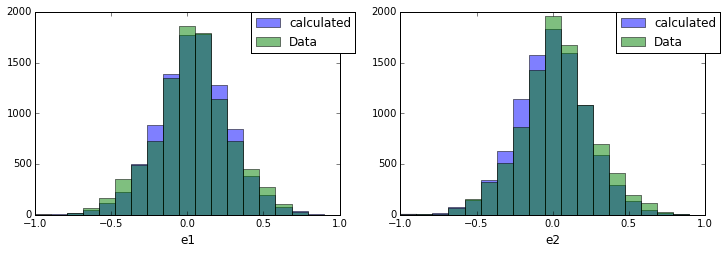

In [46]:
e_obs_cal1=e_int+np.mean(g1)+np.random.normal(0,sigmak)
e_obs_cal2=e_int+np.mean(g2)+np.random.normal(0,sigmak)
e_obs_cal=np.hypot(e_obs_cal1,e_obs_cal1)

plt.subplot(2,2,1)
plt.hist(e_obs_cal1,np.linspace(-1,1,20),alpha = 0.5, label='calculated')
plt.hist(e1_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e1',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


plt.subplot(2,2,2)
plt.hist(e_obs_cal2,np.linspace(-1,1,20), alpha = 0.5,label='calculated')
plt.hist(e2_c,np.linspace(-1,1,20),alpha = 0.5, label='Data')
plt.xlabel('e2',size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)


#plt.savefig('final_3.png')

## Ignore for now

In [ ]:
new_gmm=gmm_param(means=np.mean(m[200:],axis=0),covars=np.mean(s[200:],axis=0),weights=np.mean(w[200:],axis=0))
def f(gmm_param, x):
    sum=0
    for i in range(len(gmm_param.means)):
        sum+=gmm_param.weights[i]*np.exp(-((x-gmm_param.means[i])**2)/(2*gmm_param.covars[i]))/((2*np.pi*gmm_param.covars[i])**0.5)
    return sum
xmin = 0.0
xmax = 1.0

# find ymin-ymax
numSteps = 1000000 # bigger the better but slower!
ymin = f(new_gmm,xmin)
ymax = ymin
for i in range(numSteps):
    x = xmin + (xmax - xmin) * float(i) / numSteps
    y = f(new_gmm,x)
    if y < ymin: ymin = y
    if y > ymax: ymax = y

In [ ]:
n = len(e_cutoff) # how many random numbers to generate
e_int=[]
for i in range(n):
    while True:
        # generate a random number between 0 to 1
        xr = np.random.random()
        yr = np.random.random()
        x = xmin + (xmax - xmin) * xr
        y = ymin + (ymax - ymin) * yr
        if y <= f(new_gmm,x):
            e_int.append(xr)
            break

In [ ]:
new_d=create_gmm(new_gmm, e_cutoff)
es=np.linspace(0,max(e_cutoff),len(e_cutoff))

plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('Observed |e| with cutoff')
plt.subplot(3,3,2)
plt.hist(e_int,np.linspace(0,1,20))
plt.xlabel('Intrinsic shape Sampled from GMM')
plt.subplot(3,3,3)
plt.plot(es,new_d,label=r'$\Sigma_i w_i \mathcal{N}(\mu_i,\sigma_i)$')
plt.xlabel('GMM pdf')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.suptitle('Intrinsic shape pdf from MCMC; $N_g=5$',size=16)
plt.show()

### MCMC Results for instrinsic shape 

In [ ]:
print('MCMC GMM Means    :', new_gmm.means)
print('MCMC GMM Variances:', new_gmm.covars)
print('MCMC GMM Weights  :', new_gmm.weights)

In [ ]:
rshr=np.mean(chain[2000:])

e_lens_obt=e_int+rshr

### Cross-check : Can we reproduce the catalog data ?
- Draw intrinsic shape samples from pdf we just got
- Shear by g we just got. 
- Observed with an error $\sigma_k$

In [ ]:
e_meas=e_lens_obt+np.random.normal(0, sigmak, len(e_int))
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
plt.hist(e_cutoff,np.linspace(0,1,20))
plt.xlabel('Catalog Observed |e| ')
plt.subplot(3,3,2)
plt.hist(e_meas,np.linspace(0,1,20))
plt.xlabel('Results Observed |e|')

### Oooooppss!!!! The model was wrong!

$e^{obs}_{1,k}=e_{1,k}+g_{1,k}$ and $ e^{obs}_{2,k}=e_{2,k}+g_{2,k}$

The above model took just the sum of the magnitudes



### Correct sampling 
### $Pr(e^{obs}_1,e^{obs}_2|e^{lens}_1,e^{lens}_2,\sigma)=\prod_{k}\frac{1}{\sqrt{2\pi}\sigma_k} e^\frac{−\bigg((e^{obs}_{1,k}−e^{lens}_{1,k})^2+(e^{obs}_{2,k}−e^{lens}_{2,k})^2\bigg)}{2\sigma_k^2}$

### $Pr(e^{obs}_1,e^{obs}_2|\{w_i,\sigma_i,\mu_i\},g)  \propto \frac{1}{|e_k|} \prod_{k} \sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g+g,\sqrt{\sigma_k^2+{\sigma_i^g}^2})$         



In [ ]:
# Display:
Image(filename="jl2.png",width=800)

### Correct Joint likelihood, $Pr(e^{obs}|\{w_i^g,\sigma_i^g,\mu_i^g\},g)$ 

Since the intrinsic ellipticities are not interesting, we marginalize them out:
\begin{align}
Pr(e^{obs}_1,e^{obs}_2|\{w^g_i,\sigma^g_i,\mu^g_i\},g) & = \prod_{k} \int \int Pr(e^{obs}_1,e^{obs}_2|e^{lens}_1,e^{lens}_2,\sigma_k)\times Pr(e^{lens}_k|e_k,g) \times  Pr(e_k|\{w_i^g,\sigma_i^g,\mu_i^g\}) \,de_k \,de^{lens}_k\\
                                     & = \prod_{k}  \int \frac{1}{\sqrt{2\pi}\sigma_k} e^\frac{−\bigg((e^{obs}_{1,k}−(e_{1,k}+g_{1,k})^2+(e^{obs}_{2,k}−(e_{2,k}+g_{2,k}))^2\bigg)}{2\sigma_k^2} \times  \frac{1}{|e_k|}\sum_i^{N_g} w_i^g \mathcal{N}(\mu_i^g+g,\sqrt{\sigma_k^2+{\sigma_i^g}^2})\\
\end{align} 
    

In [ ]:
from scipy.special import erf

In [ ]:
erf(np.sqrt(-1))

In [ ]:
4*2178

In [ ]:
114/6

In [ ]:
eas